In [20]:
# Import required libraries

import numpy as np
import matplotlib.pyplot as plt
from scipy.io import loadmat

from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier

In [21]:
# Importing the Data                                                                       Shape

Endg_Truth = loadmat('end6_groundTruth.mat')      
Ground_Truth = loadmat('groundTruth.mat')               
Urban = loadmat('Urban_R162.mat')                 
image = Urban['Y'].T                                                                #    94249*162  
groundTruth = Ground_Truth ['groundTruth']                                          #     307*307
image_shape = (Ground_Truth ['nRow'], Ground_Truth ['nCol'], image.shape[1])


def hyper_to_2D(img):
    """
    
    Converts a 3D HSI cube (m x n x p) to a 2D matrix of points (N X p)
+   N = m*n, p := number of bands

    """
    img = np.array(img)
    ndim = img.ndim

    if ndim not in [2, 3]:
      raise "invalid dimention. ndim = 2 or 3"

    if ndim == 2:
      m, n = np.shape(img)
      
      hyper_img = np.empty((m,n,1))
      hyper_img[:,:,0] = img

      return hyper_to_2D(hyper_img).ravel()

    m, n, p = np.shape(img)
    N = n * m
    
    dataset = img.T.reshape((p, N)).T

    if p == 1:
      return dataset.ravel()
    
    return dataset

image = image
groundTruth = hyper_to_2D(groundTruth)

print(image.shape)
print(groundTruth.shape)


(94249, 162)
(94249,)


In [22]:
# Standardization
# Split into train (2/3) and test (1/3) sets

image = StandardScaler().fit_transform(image)
seed = 40
X_train, X_test, y_train, y_test = train_test_split(image, groundTruth, test_size = 0.30 , train_size = 0.70 , random_state = seed , stratify=groundTruth)
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)


(65974, 162)
(28275, 162)
(65974,)
(28275,)


In [24]:
# Correlation base Feature Selection

threshold = 0.008

def Correlation_base_Feature_Selection(dataset, threshold):
    nBand = dataset.shape[1]
    
    corr = np.corrcoef(dataset.T) 
    diff = 1 - corr
    
    correlated= np.where(diff < threshold, 0, 1)
    np.fill_diagonal(correlated, 1)

    # select bands
    seleted_bands = np.arange(nBand)[correlated.all(axis=0)]
    
    return seleted_bands

selected_features = Correlation_base_Feature_Selection(X_train, threshold)


In [25]:
print(selected_features)

[ 51  52  53  81 161]


In [26]:
# KNN 

for k in range(1,10):
    Model = KNeighborsClassifier(n_neighbors=k)
    Model.fit(X_train[:, selected_features], y_train)
    predict = Model.predict(X_test[:, selected_features])
    acc_train = Model.score(X_train[:, selected_features], y_train)
    acc_test = Model.score(X_test[:, selected_features], y_test)
    print(f'number {k} ', acc_train , acc_test)
    

number 1  0.9998484251371752 0.8082758620689655
number 2  0.9099039015369691 0.8033244916003537
number 3  0.904250159153606 0.8313351016799293
number 4  0.8903507442325764 0.8295667550839965
number 5  0.8866523175796526 0.8385145888594164
number 6  0.8810592051414193 0.8383731211317418
number 7  0.8791342043835451 0.8412732095490716
number 8  0.8755115651620335 0.8395755968169761
number 9  0.8738290841846789 0.8429708222811672


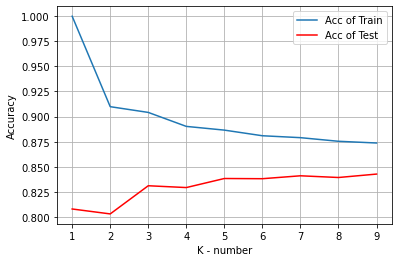

In [35]:

x1 = np.array([1, 2,3,4,5,6,7,8,9])
y1 = np.array([0.9998, 0.9099 ,0.9042 , 0.8903 ,0.8866 ,0.8810 ,0.8791,0.8755,0.8738 ])
x2 = np.array([1, 2,3,4,5,6,7,8,9])
y2 = np.array([0.8082,0.8033 ,0.8313 ,0.8295,0.8385 ,0.8383 ,0.8412 , 0.8395, 0.8429])
plt.plot(x1, y1, x2, y2,'r')

plt.xlabel('K - number')
plt.ylabel('Accuracy')
plt.legend(['Acc of Train', 'Acc of Test']);
plt.grid()
plt.show()